# Simulating Ultra narrowband Metasurface

In this simulation of [Paper Link](https://duke.box.com/s/owa6sdzf80y0u7xjp1qxia62md6z514q), I did 1200-1600nm parameter sweep, and linear polarization. Finding the transmittance of this structure.

## Preconditions

In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library
import scienceplots

td.config.logging_level = "ERROR"

In [ ]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.500, wvl_max=1.520)
N = 501 # num_points
fwidth = fr.fmax - fr.fmin
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

In [3]:
# 1 Computational Domain Size
h = 0.210  # Height of cylinder
spc = 8
sh = 3  # height of the SiO2
Lz = spc + h + spc + h

Px = Py = P = 0.750 # periodicity
sim_size = [Px, Py, Lz]

---

In [4]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [5]:
# 3 Structures and Materials
R = 0.235  # radius of the cylinder
r = 0.030  # radius of the inner hole
p = 0.080  # distance between hole to center of circle
theta = np.deg2rad(90) # angle between x-axis and p vector

Si = material_library['cSi']['Green2008']
SiO2 = material_library['SiO2']['Horiba']

outer_cylinder = td.Cylinder(
    center=[0, 0, h / 2], 
    radius=R, 
    length=h, 
    axis=2
)

inner_cylinder = td.Cylinder(
    center=[p*np.cos(theta), -p*np.sin(theta), h / 2], 
    radius=r, 
    length=h, 
    axis=2
)

cylinder = td.ClipOperation(
    operation="difference",
    geometry_a=outer_cylinder,
    geometry_b=inner_cylinder
)

atom = td.Structure(
    geometry=cylinder, 
    medium=Si,
    name="metaatom"
)

dioxide = td.Structure(
    geometry=td.Box(
        center=[0,0,-sh/2],
        size=(td.inf,td.inf, sh)
    ),
    medium=SiO2, 
    name="silicon dioxide"
)

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc - (sh - h)))
    ),
    medium=Si,
    name='substrate'
)

---

In [6]:
def circular_polarized_plane_wave(pol):
    # define a plane wave polarized in the x direction
    plane_wave_x = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=0,
    )

    # determine the phase difference given the polarization
    if pol == "left":
        phase = -np.pi / 2
    elif pol == "right":
        phase = np.pi / 2
    else:
        raise ValueError("pol must be `left` or `right`")

    # define a plane wave polarized in the y direction with a phase difference
    plane_wave_y = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=phase),
        size=(td.inf, td.inf, 0),
        center=(0, 0,-Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=np.pi / 2,
    )

    return [plane_wave_x, plane_wave_y]


In [7]:
monitor = td.DiffractionMonitor(
    center=(0, 0, Lz/2 - spc + 1.5 * lda0),
    size=(td.inf,td.inf,0),
    freqs=fr.freqs(N),
    name='diffraction_monitor',
    normal_dir='+', # away from structure
)

---

In [8]:
bandwidth = fr.fmax - fr.fmin
run_time = 200 / bandwidth # run_time for the transmittance simulation

In [9]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Simulation

In [10]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, dioxide, atom],
    sources=circular_polarized_plane_wave("right"),
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=bc
)

In [12]:
sim.plot_3d()

In [13]:
# upload the simulation to our servers
task_id = web.upload(sim, task_name="circular", verbose=True)

# start the simulation running
web.start(task_id)

# monitor the simulation, don't move on to next line until completed.
web.monitor(task_id, verbose=True)

# download the results and load into a simulation data object for plotting, post processing etc.
sim_data = web.load(task_id, path="data/circular.hdf5", verbose=True)


17:26:51 EDT Created task 'circular' with task_id                               
             'fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=879829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=725824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\taskId]8;;\]8;id=879829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\=]8;;\]8;id=522739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\fdve]8;;\]8;id=879829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\-275dd7f9-ea1]8;;\
             ]8;id=879829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-275dd7f9-ea16-44fe-ba14-7d567b82ce9d\6-44fe-ba14-7d567b82ce9d']8;;\.

             Task folder: ]8;id=717391;https://tidy3d.simulation.cloud/folders/folder-4a96f49a-40a0-4d85-a7de-71d7af0d2c31\'default']8;;\.

Output()

17:26:53 EDT Maximum FlexCredit cost: 2.948. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:26:54 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

KeyboardInterrupt: 

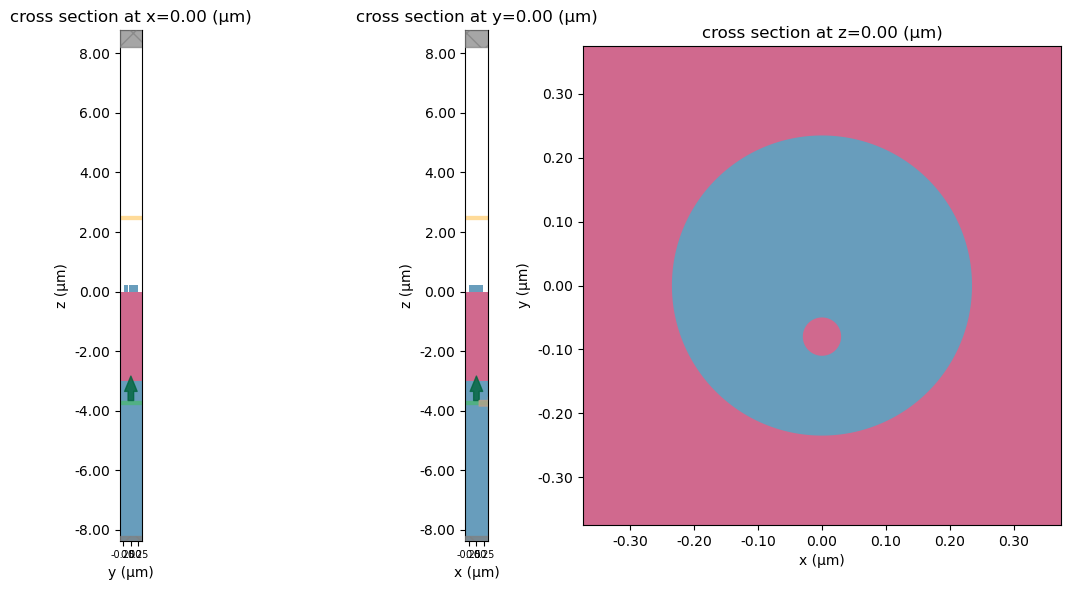

In [16]:
# Always visualize simulation before running
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 6))
ax1.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
sims["actual"].plot(x=0, ax=ax1)
# sim_actual.plot_grid(x=0, ax=ax1)
sims["actual"].plot(y=0, ax=ax2)
# sim_actual.plot_grid(y=0, ax=ax2)
sims["actual"].plot(z=0, ax=ax3)
# sim_actual.plot_grid(z=0, ax=ax3)
plt.savefig(f'geomp_structure.png', dpi=300)
plt.show()

In [17]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/geom_linear2")

Output()

23:42:18 EDT Started working on Batch containing 2 tasks.

23:42:20 EDT Maximum FlexCredit cost: 5.789 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

23:42:21 EDT Batch complete.

Output()

## Circular Polarization

In [18]:
def circular_polarized_plane_wave(pol):
    # define a plane wave polarized in the x direction
    plane_wave_x = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=0,
    )

    # determine the phase difference given the polarization
    if pol == "left":
        phase = -np.pi / 2
    elif pol == "right":
        phase = np.pi / 2
    else:
        raise ValueError("pol must be `left` or `right`")

    # define a plane wave polarized in the y direction with a phase difference
    plane_wave_y = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=phase),
        size=(td.inf, td.inf, 0),
        center=(0, 0,-Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=np.pi / 2,
    )

    return [plane_wave_x, plane_wave_y]


In [19]:
def make_sim(pol):
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, dioxide, atom],
        sources=circular_polarized_plane_wave(pol),
        monitors=[monitor],
        run_time=run_time,
        boundary_spec=bc
    )
    return sim

In [20]:
sim_left = make_sim("left")
sim_left.plot_3d()

In [21]:
# define simulations
sims = {
    "LCP": sim_left,
    "RCP": make_sim("right")
}


In [22]:
# create a batch and run all sims in parallel
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data/circular")

Output()

23:42:27 EDT Started working on Batch containing 2 tasks.

23:42:29 EDT Maximum FlexCredit cost: 5.893 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

23:42:30 EDT Batch complete.

Output()

In [24]:
T_lcp = batch_results["LCP"]["flux_monitor"].flux 
T_rcp = batch_results["RCP"]["flux_monitor"].flux

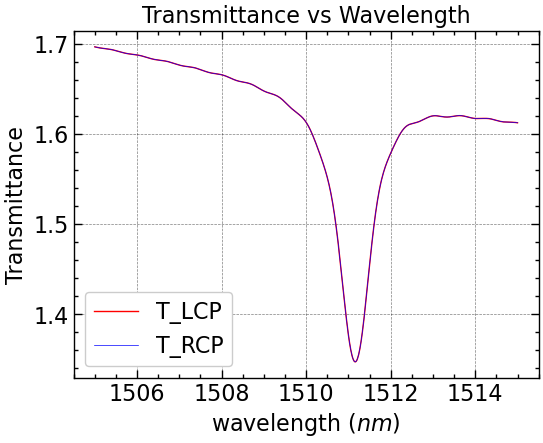

In [25]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_lcp, "r", lw=1, label="T_LCP")
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_rcp, "b", lw=0.5, alpha=1, label="T_RCP")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.legend()
plt.title("Transmittance vs Wavelength")
plt.savefig("power_circular", dpi=300)
plt.show()

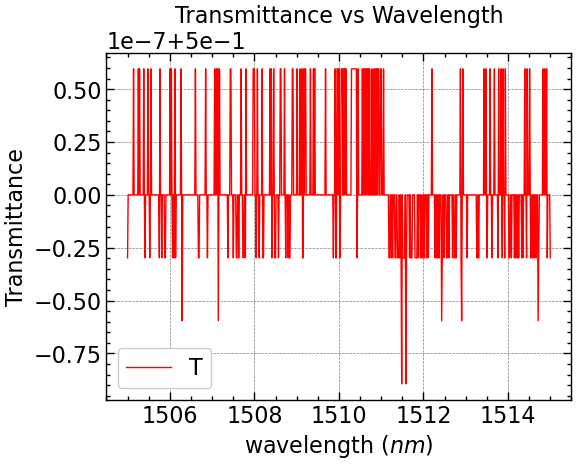

In [26]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_lcp / (T_lcp + T_rcp), "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.legend()
plt.title("Transmittance vs Wavelength")
plt.savefig("power_lcprcp", dpi=300)
plt.show()